<a href="https://colab.research.google.com/github/eeshahar/data-science/blob/main/Eesha_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [2]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

cs_data

,ID,aa,theo,exp,diff_TminusE,cat
0,1BM8,ILE,61.18,58.27,2.91,Non-Polar
1,1BM8,TYR,56.95,56.18,0.77,Polar
2,1BM8,SER,56.35,56.84,-0.49,Polar
3,1BM8,ALA,51.96,51.01,0.95,Special
4,1BM8,ARG,56.54,54.64,1.90,Charged
...,...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,-1.72,Charged
1772,1KS9,ARG,58.91,59.02,-0.11,Charged
1773,1KS9,LYS,59.49,58.92,0.57,Charged
1774,1KS9,GLU,59.48,58.36,1.12,Charged


In [3]:
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode
aa_idx = aa_encode.codes
aa_idx
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model:
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 10, nu = 30)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10, nu = 30)
    μ_nm = pm.HalfStudentT('μ_nm', sigma = 10, nu = 30)

    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  nu = μ_nm,
                  dims = "aa")

    σ = pm.HalfStudentT('σ',
                        sigma = 10,
                        nu = 30,
                        dims = "aa")
    ν = pm.HalfStudentT('ν',
                        sigma = 10,
                        nu = 30,
                        dims = "aa")

    y = pm.StudentT('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  nu = ν[aa_idx],
                  observed = cs_data.diff_TminusE)
#cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model2:
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    idata_cs_h2 = pm.sample()

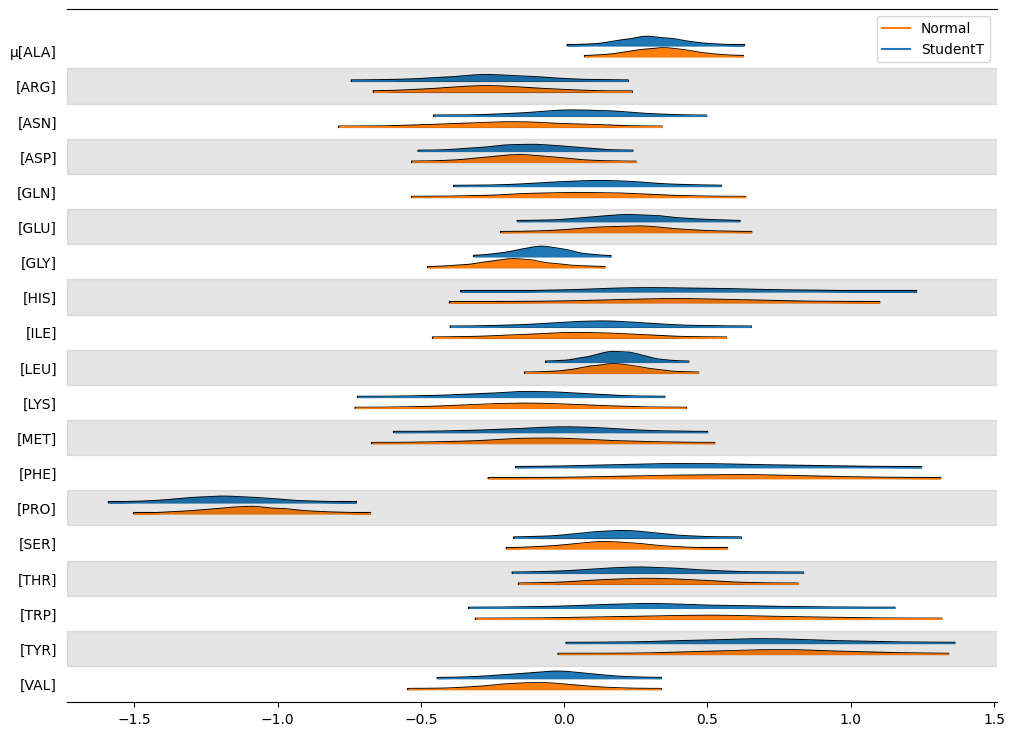

In [8]:
axes = az.plot_forest([idata_cs_h, idata_cs_h2], kind="ridgeplot",
                      model_names=['StudentT', 'Normal'],
                      var_names='μ', combined=True, figsize=(12, 9),hdi_prob=0.997)


**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

In [ ]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)


(-10.0, 10.0)

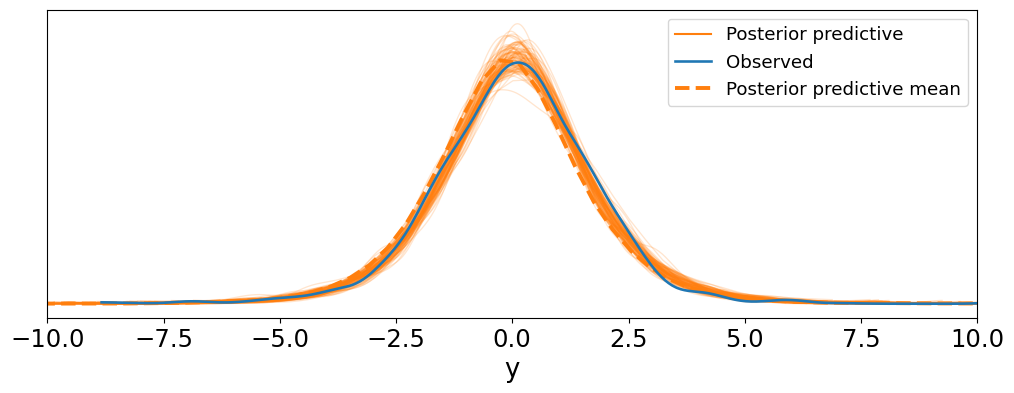

In [13]:
ax = az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(-10, 10)



In [ ]:
pm.sample_posterior_predictive(idata_cs_h2, model=cs_h_model2, extend_inferencedata=True)



(-10.0, 10.0)

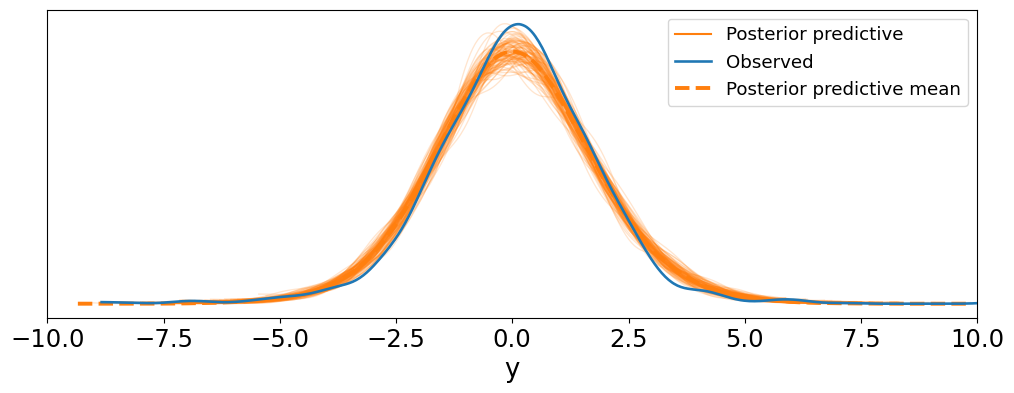

In [15]:
ax = az.plot_ppc(idata_cs_h2, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(-10, 10)

The StudentT model fits a lot better, especially at the top of the distribution, where the Normal model is well below the observed. The StudentT model also fits the sides better than the Normal model.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [17]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})
sccr_data


,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [18]:
pos_idx = sccr_data.position.cat.codes.values
pos_codes = sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}

In [ ]:

with pm.Model(coords = sccr_coords) as sccr_model:
    # priors
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20, dims = "pos")
    ν = pm.Gamma('ν', mu = 55, sigma = 45, dims = "pos")


    # Parameters for positions
    #μ = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

   # ν = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ[pos_idx], nu = ν[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_nh = pm.sample(target_accept = 0.95)


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>]],
      dtype=object)

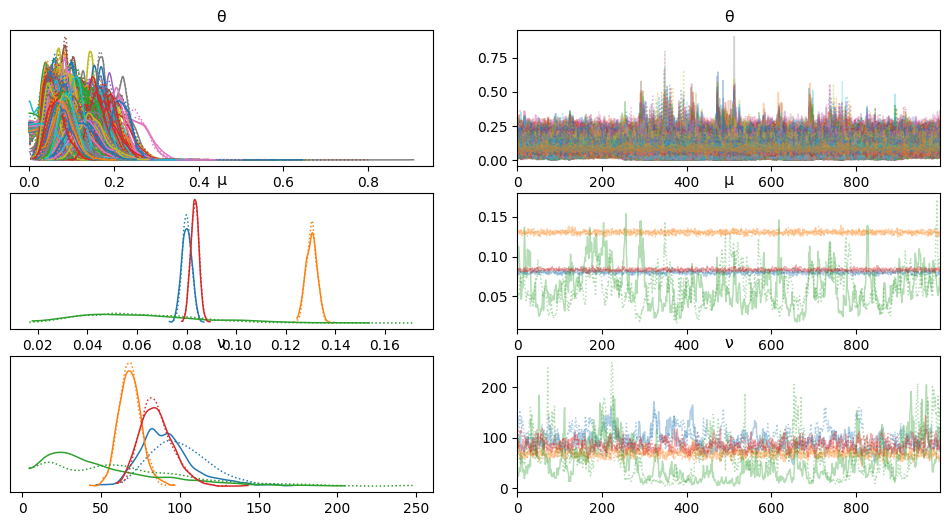

In [22]:
az.plot_trace(idata_sccr_nh)

In [ ]:
az.rhat(idata_sccr_nh)

The nonhiercharcal is further from 1 than the heircharcal values for μ, ν, and θ. For the traces, theta was similar between both hierarchial and nonhierarchial, as both stretched to be longer then 0.75. I would say that the nonhierarchial model had more outliers in amplitude.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

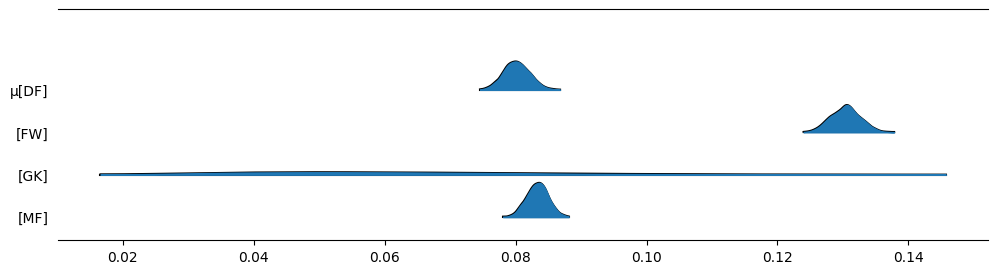

In [24]:
az.plot_forest(idata_sccr_nh, var_names=['μ'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

The posteriors of the hierarchical and nonhierarchical model close. For everything except GK, the sizes and shapes of the curves almost identical. One difference is that the ranges on the x-axes are slightly different between the two models.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [30]:
sccr_data_2 = pd.read_csv(url_sccr)
sccr_data = sccr_data[sccr_data.position != 'GK']
sccr_data_2['position'] = sccr_data_2['position'].astype('category')
sccr_data_2

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [32]:
pos_idx_2 = sccr_data_2.position.cat.codes.values

pos_codes_2 = sccr_data_2.position.cat.categories

sccr_coords_2 = {"pos": pos_codes_2}


In [ ]:
with pm.Model(coords = sccr_coords_2) as sccr_model_h: # hierarchical without goalkeepers
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx_2], nu = ν_p[pos_idx_2])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data_2.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data_2.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_h = pm.sample(target_accept = 0.95)

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.004 1.0 1.001 1.003 ... 1.003 1.001 1.006
    μ        float64 8B 1.005
    μ_p      (pos) float64 32B 0.9996 0.9999 1.042 1.0
    ν        float64 8B 1.001
    ν_p      (pos) float64 32B 1.035 1.002 1.065 1.015

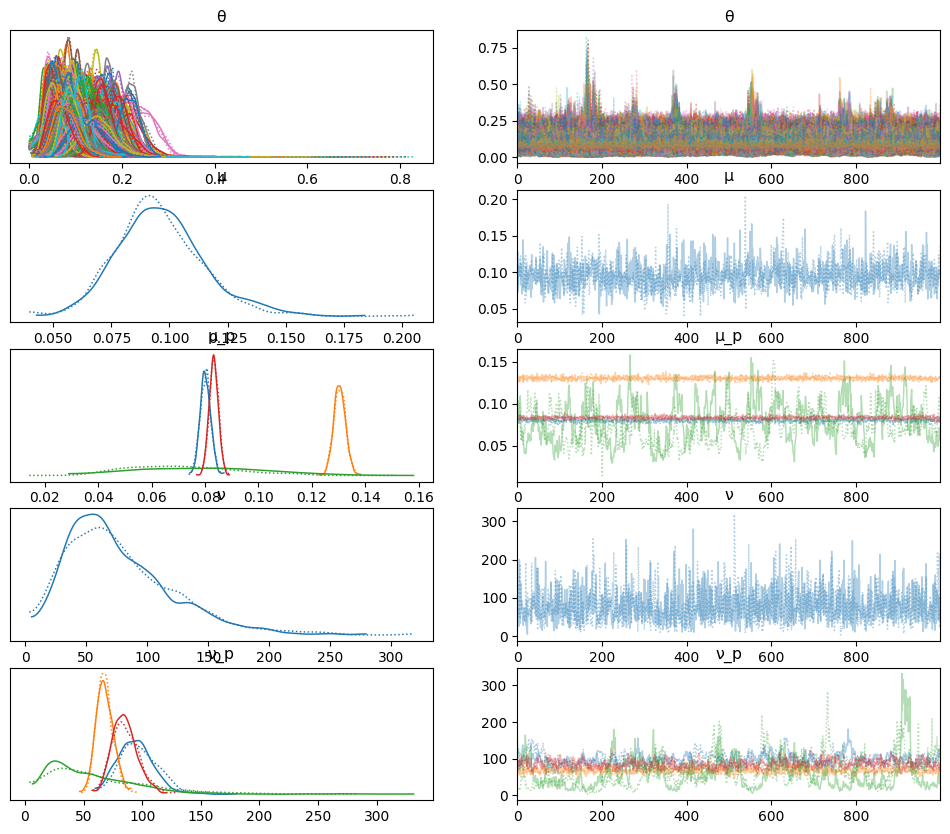

In [36]:
az.plot_trace(idata_sccr_h2)
az.rhat(idata_sccr_2)



By dropping goalkeeper data, we lose some precision in the graphs, but we make the overall graphs much better.